TODO list:
* Add test loss (Davit)
* Refactor forward and backward (Igor) - Done
* Make get_params to return dictionary (Davit)
* Check parameter init with DL course (Davit)
* Think about output shape. Transpose output to N * 2 (Igor) - Done
* Add constructor for sequential (Igor)
* Maybe add batchsize sgd (Davit) - Done by Igor in process of testing output shape
* Add more sophisticated sgd method (Davit)
* Maybe add more layer types (Dropout if we overfit) (Oganes)
* Maybe add more layer types (Binary Cross Entropy) (Davit)
* Add comments (Davit)
* Start report (Igor)
* Make module names lowercase (Igor)
* See why model with 100 hidden neurons is not converging (Noone)

In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import math
from IPython import display
matplotlib.style.use('ggplot')
torch.set_grad_enabled(False)

from Utilities import generate_disc_set, compute_nb_errors, get_batches
from Loss import Loss, MSE
from Module import DenseLayer, ReLU, Sequential, Tanh

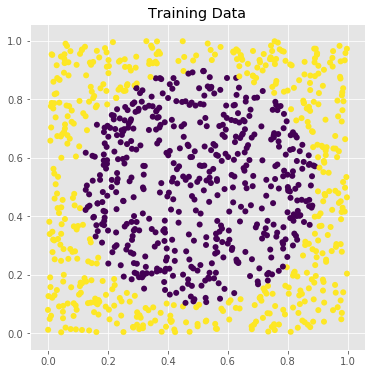

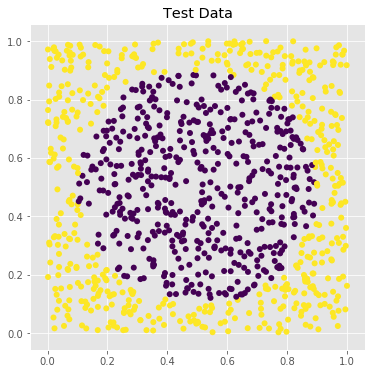

In [2]:
train_size = 1000
test_size = 1000

train_data, train_target = generate_disc_set(train_size)
test_data, test_target = generate_disc_set(test_size)

plt.figure(figsize=(6,6))
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_target[:, 0].numpy(), edgecolors='none')
plt.title('Training Data')
plt.show()


plt.figure(figsize=(6,6))
plt.scatter(test_data[:, 0], test_data[:, 1], c=test_target[:, 0].numpy(), edgecolors='none')
plt.title('Test Data')
plt.show()

In [3]:
net_loss = MSE()

In [4]:
def create_model(n_hidden=50):
    net = Sequential()
    net.add(DenseLayer(2, n_hidden))
    net.add(ReLU())
    net.add(DenseLayer(n_hidden, n_hidden))
    net.add(ReLU())
    net.add(DenseLayer(n_hidden, 2))
    return net

In [5]:
n_hidden = 50
net = create_model(n_hidden)
print(net)

Linear 2 -> 50
ReLU
Linear 50 -> 50
ReLU
Linear 50 -> 2



In [6]:
def sgd(x, dx, config):
    for cur_layer_x, cur_layer_dx in zip(x, dx):
        for cur_x, cur_dx in zip(cur_layer_x, cur_layer_dx):

            cur_old_grad = config['learning_rate'] * cur_dx

            if cur_old_grad.shape[0] == 1:
                cur_x = cur_x.reshape(cur_old_grad.shape)

            cur_x.add_(-cur_old_grad)

In [7]:
def train_model(model, model_loss, train_data, train_target, lr=0.005, plot_loss=False, n_epoch=60):
    optimizer_config = {'learning_rate': lr}
    batch_size = 1
    loss_history = []

    for i in range(n_epoch):
        loss = 0
        for x_batch, y_batch in get_batches(train_data, train_target, batch_size):
            model.zero_grad_params()

            # Forward
            pred = model.forward(x_batch)
            loss += model_loss.forward(pred, y_batch)
            
            # Backward
            lg = model_loss.backward(pred, y_batch)
            model.backward(lg)
            
            # Update weights
            sgd(net.get_params(), 
                net.get_grad_params(), 
                optimizer_config)      
        
        loss_history.append(loss)
        
        if plot_loss:
            # Visualize
            display.clear_output(wait=True)
            plt.figure(figsize=(8, 6))
        
            plt.title("Training loss")
            plt.xlabel("#iteration")
            plt.ylabel("loss")
            plt.plot(loss_history, 'b')
            plt.show()
    
            print('Current loss: %f' % loss)

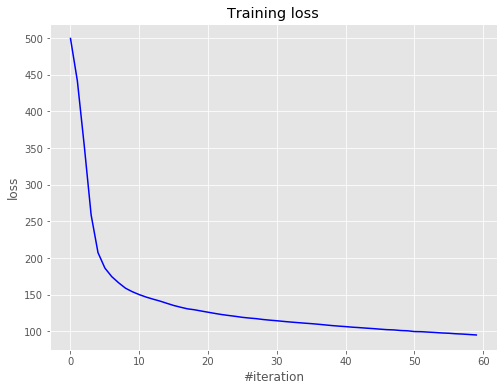

Current loss: 95.168976


In [8]:
train_model(net, net_loss, train_data, train_target, plot_loss=True, n_epoch=60)

In [9]:
train_res = net.forward(train_data)
errors_train = compute_nb_errors(train_res, train_target)
print(f"Number of errors on a train set: {errors_train}")
train_res = train_res.argmax(1)
train_res[train_res != train_target.argmax(1)] = 2

Number of errors on a train set: 12


In [10]:
test_res = net.forward(test_data)
errors_test = compute_nb_errors(test_res, test_target)
print(f"Number of errors on a test set: {errors_test}")
test_res = test_res.argmax(1)
test_res[test_res != test_target.argmax(1)] = 2

Number of errors on a test set: 20


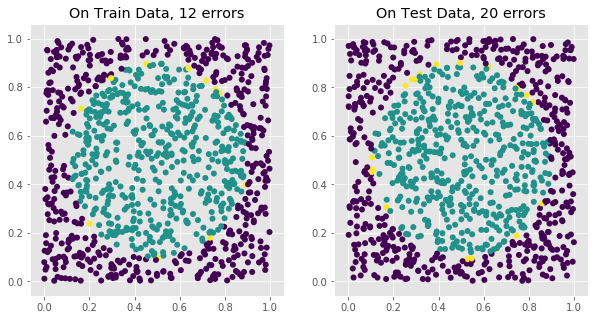

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_res, edgecolors="none")
plt.title(f'On Train Data, {errors_train} errors')

plt.subplot(1, 2, 2)
plt.scatter(test_data[:, 0], test_data[:, 1], c=test_res, edgecolors="none")
plt.title(f'On Test Data, {errors_test} errors')
plt.show()

### Plot decision boundaries

In [12]:
import numpy as np
import matplotlib.patches as mpatches

In [20]:
def visualize_decision_boundaries(model, N=100, title=None):
    xs = np.linspace(0, 1, N)
    ys = np.linspace(0, 1, N)
    xs, ys = np.meshgrid(xs, ys)
    xs, ys = xs.flatten(), ys.flatten()
    
    results = []
    for x, y in zip(xs, ys):
        results.append(model.forward(torch.tensor([x, y]).unsqueeze(0)).argmax().item())
    
    colors = {0:'red',1:'blue'}
    result_colors = [colors[res] for res in results]
    labels = ['Class 1','Class 2']

    plt.figure(figsize=(5, 5))
    plt.scatter(xs, ys, c=result_colors)
    if title:
        plt.title(title + " model's decision boundaries")
    else:
        plt.title("Model's decision boundaries")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    
    recs = []
    for i in range(len(labels)):
         recs.append(mpatches.Rectangle((0,0), 1, 1, fc=list(colors.values())[i]))
    plt.legend(recs, labels, loc=4, ncol=3)

    plt.show()

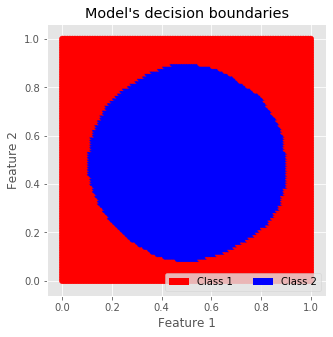

In [21]:
visualize_decision_boundaries(net)

Let's see the importance of number of hidden neurons

In [15]:
test_different_hidden_sizes = True

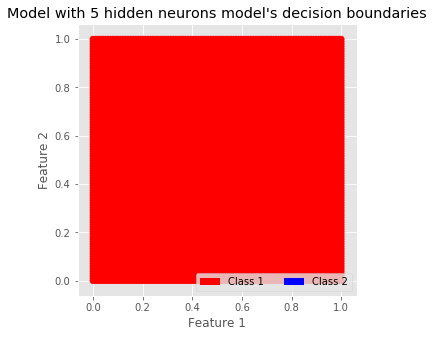

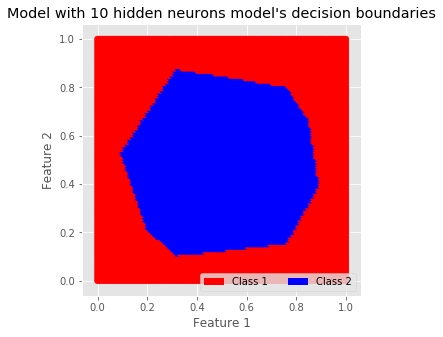

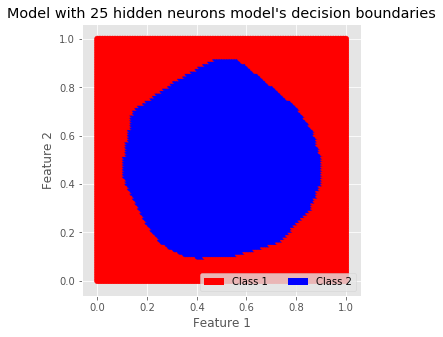

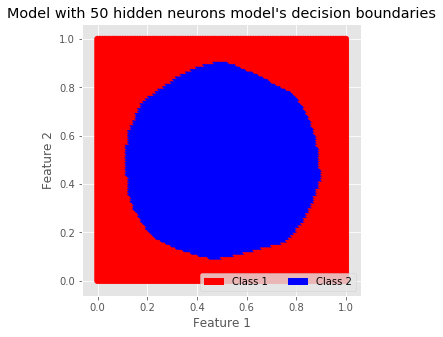

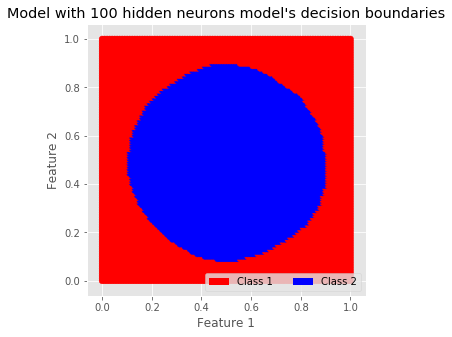

In [16]:
if test_different_hidden_sizes:
    for n_hidden in [5, 10, 25, 50, 100]:
        net = create_model(n_hidden)
        train_model(net, net_loss, train_data, train_target, n_epoch = 40)
        visualize_decision_boundaries(net, title=f"Model with {n_hidden} hidden neurons")

Our observations:
* Decision boundary's shape is becoming closer to circle with more hidden neurons. 
* There is no significant improvement after number of hidden neurons more than 25